<a href="https://colab.research.google.com/github/bartlomiejandruchow/AI/blob/main/kerasAPIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras import layers


In [ ]:
# Seqential API

model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

In [ ]:
model = keras.Sequential(name="my_example_model")

model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
#model.build(input_shape=(None,3))
model.summary()


In [ ]:
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))
model.summary()

#model.weights

In [ ]:
# Functional API

inputs = keras.Input(shape=(3,))
print(inputs.dtype)

features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs, name="my_functional_model")

model.summary()


In [ ]:
# Subclassing Model class
import keras
from keras import layers


class CustomerTicketModel(keras.Model):
  def __init__(self, num_departments):
    super.__init__()
    self.concat_layer = layers.Concatenate()
    self.mixing_layer = layers.Dense(64, activation="relu")
    self.priority_scorer = layers.Dense(1, activation="sigmoid")
    self.department_classifier = layers.Dense(num_departments, activation="softmax")

  def call(self, inputs):
    title = inputs["title"]
    text_body = inputs["text_body"]
    tags = inputs["tags"]

    features = self.concat_layer([title, text_body, tags])
    features = self.mixing_layer(features)
    priority = self.priority_scorer(features)
    department = self.department_classifier(features)
    return priority, department


model = CustomerTicketModel(num_departments=4)
pririty, department = model({"title":title_data,"text_body":text_body_data, "tags":tags_data })


In [40]:
from keras.datasets import mnist
import keras
from keras import layers

def get_mnist_model():
  inputs = keras.Input(shape=(28 * 28,))
  features = layers.Dense(512, activation="relu")(inputs)
  features = layers.Dropout(0.5)(features)
  outputs = layers.Dense(10, activation="softmax")(features)
  model = keras.Model(inputs, outputs)
  return model

(images,labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28*28)).astype("float32") / 255

train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

print(train_images.shape)
print(train_labels.shape)
print(train_labels[0:10])

model = get_mnist_model()
model.compile(
    optimizer="rmsprop",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
)

model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)



(50000, 784)
(50000,)
[3 8 7 9 9 0 1 1 5 2]
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8522 - loss: 0.4938 - val_accuracy: 0.9568 - val_loss: 0.1473
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9493 - loss: 0.1659 - val_accuracy: 0.9641 - val_loss: 0.1252
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9629 - loss: 0.1289 - val_accuracy: 0.9680 - val_loss: 0.1087
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9686 - loss: 0.1033 - val_accuracy: 0.9743 - val_loss: 0.0897
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9736 - loss: 0.0879 - val_accuracy: 0.9749 - val_loss: 0.0889
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9708 - loss: 0.0952
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [39]:
from keras import ops
print(predictions[0])
print(test_labels[0])
print(ops.one_hot(test_labels[0], num_classes=10))

[5.5088836e-09 1.9157944e-11 2.0013839e-08 7.4632072e-07 6.6625674e-14
 6.2929478e-10 9.1086086e-15 9.9999911e-01 2.7786967e-10 9.8763479e-08]
7
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)


In [41]:
from keras import ops

class RootMeanSquaredError(keras.metrics.Metric):
  def __init__(self, name="rmse",  **kwargs):
    super().__init__(name=name, **kwargs)
    self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
    self.total_samples = self.add_weight(name="total_samples", initializer="zeros")

  def update_state(self, y_true, y_pred, sample_weight = None):
    y_true = ops.one_hot(y_true, num_classes=ops.shape(y_pred)[1])
    mse = ops.sum(ops.square(y_true - y_pred))
    self.mse_sum.assign_add(mse)
    num_samples = ops.shape(y_pred)[0]
    self.total_samples.assign_add(num_samples)
    # In classification settings, if y_true is an integer class (sparse label)
    # , you often convert it into a one-hot vector to compare it with y_pred
    # (which is usually probabilities or logits after softmax).

  def result(self):
    return ops.sqrt(self.mse_sum / self.total_samples)

  def reset_state(self):
    self.mse_sum.assign(0.)
    self.total_samples.assign(0.)


In [43]:
model = get_mnist_model()
model.compile(
    optimizer="adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy", RootMeanSquaredError()],
    )

model.fit(train_images
          , train_labels
          , epochs=3
          , batch_size=64
          , validation_data=(val_images, val_labels)
          ,
          )

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8434 - loss: 0.5265 - rmse: 0.4703 - val_accuracy: 0.9569 - val_loss: 0.1495 - val_rmse: 0.2553
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9536 - loss: 0.1568 - rmse: 0.2677 - val_accuracy: 0.9690 - val_loss: 0.1055 - val_rmse: 0.2177
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9637 - loss: 0.1179 - rmse: 0.2356 - val_accuracy: 0.9719 - val_loss: 0.0923 - val_rmse: 0.2065


In [47]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    ),
]

model = get_mnist_model()
model.compile(
    optimizer="adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
    )

model.fit(train_images
          , train_labels
          , epochs=10
          , callbacks = callbacks_list
          , validation_data=(val_images, val_labels)
          ,
          )

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8615 - loss: 0.4646 - val_accuracy: 0.9609 - val_loss: 0.1375
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9529 - loss: 0.1540 - val_accuracy: 0.9707 - val_loss: 0.0946
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9658 - loss: 0.1105 - val_accuracy: 0.9747 - val_loss: 0.0854
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9704 - loss: 0.0923 - val_accuracy: 0.9769 - val_loss: 0.0763
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9748 - loss: 0.0783 - val_accuracy: 0.9779 - val_loss: 0.0741
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9758 - loss: 0.0739 - val_accuracy: 0.9777 - val_loss: 0.0755
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9782 - loss: 0.0655 - val_accuracy: 0.9767 - val_loss: 0.0832
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9797 - loss: 0

In [48]:
model = keras.models.load_model("checkpoint_path.keras")
test_metrics = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9791 - loss: 0.0715


In [50]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs):
    self.per_batch_losses = []

  def on_batch_end(self, batch, logs):
    self.per_batch_losses.append(logs.get("loss"))

  def on_epoch_end(self, epoch, logs):
    plt.clf()
    plt.plot(
        range(len(self.per_batch_losses)),
        self.per_batch_losses,
        label="Training loss for each batch"
             )
    plt.savefig(f"plot_at_epoch_{epoch}", dpi=300)
    self.per_batch_losses = []



Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8581 - loss: 0.4635 - val_accuracy: 0.9592 - val_loss: 0.1347
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9552 - loss: 0.1519 - val_accuracy: 0.9692 - val_loss: 0.1047
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9652 - loss: 0.1140 - val_accuracy: 0.9739 - val_loss: 0.0878
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9694 - loss: 0.0956 - val_accuracy: 0.9758 - val_loss: 0.0804
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9724 - loss: 0.0843 - val_accuracy: 0.9755 - val_loss: 0.0845
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9758 - loss: 0.0742 - val_accuracy: 0.9779 - val_loss: 0.0726
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9799 - loss: 0.0630 - val_accuracy: 0.9772 - val_loss: 0.0799
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9808 - loss: 0

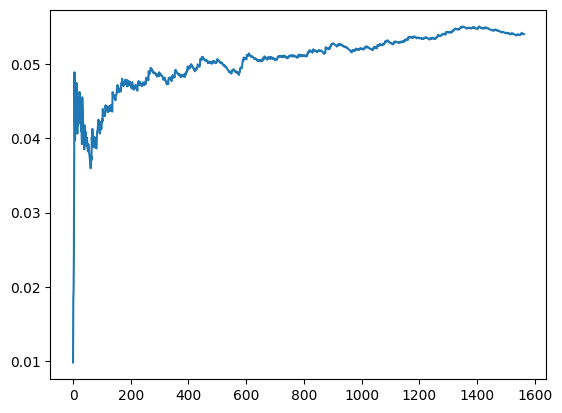

In [51]:
model = get_mnist_model()
model.compile(
    optimizer="adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
    )

model.fit(train_images
          , train_labels
          , epochs=10
          , callbacks = [LossHistory()]
          , validation_data=(val_images, val_labels)
          ,
          )